Kiedy stosuje się wielozadaniowość?

- Przy rozwiązywaniu pewnych problemów sposób z wywołaniem kolejnych  funkcji nie jest oczywisty.

- Przykładem jest problem producenta i konsumenta, w którym jedna złożona procedura generuje wiele wartości przez jakiś czas  i kolejna procedura ich używa. 

- Rozwiązanie polegające na tym,że konsument wywoła funkcję producenta nie jest wygodne, ponieważ producent może mieć więcej wartości do wygenerowania i trzeba wtedy czekać na zakończenie ich generacji, tymczasem konsument może  chcieć działać już na tych początkowych wartościach.

- Dlatego lepiej użyc mechanizmu przeplatającego - gdzie funkcje będą realizowane przez tzw. taski (inne nazwy: symmetric coroutines, lightweight threads, cooperative multitasking, one-shot continuations) 

- W tym przykładzie funkcja produce() wymusza przełączenie się na task realizujący funkcję konsument(). 

- Pętla w konsumencie iterująca po tasku producent powoduje przełączanie się na task producenta. 

- Możliwe jest wysołanie funkcji consume() wprost.

Makro @async opakowuje wyrażenie jako task i dodaje do kolejki  schedulara na <b> lokalnej</b> maszynie.

Makro @sync czeka na zakończenie się wszystkich tasków

In [1]:
println("--->")

function producent()
    println("+ producent zaczyna")
    produce("produkt 1 ")
    
    produce("produkt 2")
    println("+ producent kończy")
end

function konsument(p::Task)
    println("* konsument zaczyna")
    for s in p
        println("odebrałem ", s)
    end
    println("* konsument kończy")
end

@sync begin
    a = @async producent()
    @async konsument(a)
end

println("<---")

--->
+ producent zaczyna
* konsument zaczyna
odebrałem produkt 1 
odebrałem produkt 2
+ producent kończy
* konsument kończy
<---


In [2]:
# W Julii scheduler tasków  jest typu cooperative 
# taski są przełączane tylko w dobrze zdefiniowanych punktach synchronizacyjnych. 
# tutaj napis tworzony jest wg kolejnosci cały task x1, cały task x2 itd. (bez przełączania)


function f1()
 @sync begin
    napis=""
    for i in 1:3
        @async begin
            napis=napis * "zadanie $i "
    
            napis=napis * " ($i) etap 1 "
       
            napis= napis * " ($i) etap 2 "
      
        end
    end
 end
 napis
end

f1()

"zadanie 1  (1) etap 1  (1) etap 2 zadanie 2  (2) etap 1  (2) etap 2 zadanie 3  (3) etap 1  (3) etap 2 "

In [3]:
# yield powoduje wymuszenie przełączenia na inny, aktywny task. 
# dlatego kolejność jest pomieszana

function f2()
@sync begin
napis=""
for i in 1:3
    @async begin
        napis=napis * "zadanie $i "
        yield()
        napis=napis * " ($i) etap 1 "
        yield()
        napis= napis * " ($i) etap 2 "
        yield()
    end
end
end
  napis
end

f2()

"zadanie 1 zadanie 2 zadanie 3  (1) etap 1  (2) etap 1  (3) etap 1  (1) etap 2  (2) etap 2  (3) etap 2 "

Więcej o możliwych funkcjach wykonywanych na taskach (uzyskiwanie informacji, który task jest uruchomiony, możliwości niskopoziomowego przełączania się itd.):

https://docs.julialang.org/en/stable/stdlib/parallel/#tasks

## Wykonywanie równoległe
- Architektura master - worker.
- master - proces, z którego sterujemy wykonaniem programu
- master zleca wykonanie danej funkcji na innym procesie i ściąga wynik

In [1]:
# Uruchomienie procesów workerów (zwykle podajemy tyle, ile węzłów chcemy wykorzystać)
# jesli uruchamiamy konsole julii to można też użyć opcji 
# julia -p ilosc_workerów
# do usuwania workerów służy  rmprocs() - tylko dla procesu master !
if nprocs() == 1
    addprocs(4)
end
# wszystkie procesy
nprocs() |> println
# procesy workerów
# tablica identyfikatorów
workers() |> println
# ilość
nworkers()|> println

5
[2,3,4,5]
4


In [23]:
# każdy proces ( w tym główny) ma swój identyfikator
myid()

1

### Operacje równoległe wysokopoziomowe

In [43]:
# każda operacja I^100 wykonywana jest równolegle (map) - master nie bierze udziału w obliczeniach
# wyniki wszystkich operacji równoległych są sumowane (reduce) - wykonywana w procesie wywołującym 

@parallel (+) for i=1:1000 
        BigInt(i)^100

end

10409322085141927639670203491499689537738780837791755480023910122413796284563817273031715389609548981241768473547819207141766480065813697534743324177871972318309449519400285796191029154173386427179568557187635957090705352571527670654111047109630289487169691389452699579236618703725748994463357307313300

In [44]:
# tutaj każdy proces ma swoją kopię tablicy a, więć kod nie zadziała dobrze
# @sync - czekamy na zakończenie się wszystkich obliczeń.
# master nie bierze udziału w obliczeniach.
a = zeros(10)
@sync @parallel for i=1:10
  a[i] = i
end
a


10-element Array{Float64,1}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [45]:
# tutaj tablica jest współdzielona (SharedArray), każdy proces modyfikuje jej kawałek.

a1=SharedArray(Float64,10)
@sync @parallel for i=1:10
  a1[i] = i
end
a1



10-element SharedArray{Float64,1}:
  1.0
  2.0
  3.0
  4.0
  5.0
  6.0
  7.0
  8.0
  9.0
 10.0

In [8]:
a2=SharedArray(Int8,10)
@sync @parallel for i=1:10
  a2[i] = myid()
end
a2

10-element SharedArray{Int8,1}:
 2
 2
 2
 3
 3
 3
 4
 4
 5
 5

In [46]:
# pmap - działa podobnie jak @parallel for bez redukcji, ale jest wydajniejsza dla dłużej trwających operacji.

lst = collect(1:10)

pmap(x->myid(),lst)


10-element Array{Any,1}:
 2
 4
 5
 3
 3
 2
 3
 2
 3
 2

### Zbiór Julii

In [4]:
using Plots
Plots.gr()

# punkt o współrzędnych (x,y) należy do zbioru Julii o parametrze  c 
# jeśli dla liczby zespolonej z=x+i*y
# ciąg zₙ₊₁=zₙ²+c , nie dąży do nieskończoności

# dążenie do nieskończoności sprawdzamy ustawiająć maksymalną liczbę iteracji i sprawdzając
# czy kolejne wyrazy ciągu nie przekroczą zadanego progu (tutaj 2) w tej (bądź mniejszej)
# liczbie iteracji

# funkcja sprawdzająca, czy punkt z należy do zbioru Julii o parametrze c
function generate_julia(z; c=2, maxiter=200)
    for i=1:maxiter
        if abs(z) > 2
            return i-1
        end
        z = z^2 + c
    end
    maxiter
end

# obliczamy zbiór Julii na płaszczyźnie punktów od-do.

function calc_julia!(julia_set, xrange, yrange; maxiter=200, height=400, width_start=1, width_end=400)
   for x=width_start:width_end
        for y=1:height
            z = xrange[x] + 1im*yrange[y]
            julia_set[x, y] = generate_julia(z, c=-0.70176-0.3842im, maxiter=maxiter)
        end
    end
end

# główna funkcja 

function calc_julia_main(h,w)
  # ustawiamy płaszczyznę
    xmin, xmax = -2,2
   ymin, ymax = -1,1
   xrange = linspace(xmin, xmax, w)
   yrange = linspace(ymin, ymax, h)
	println(xrange[100],yrange[101])
   julia_set = Array(Int64, (w, h))
    
   # obliczamy
   @time calc_julia!(julia_set, xrange, yrange, height=h, width_end=w)
    
    # rysujemy
   pl=Plots.heatmap(xrange, yrange, julia_set)
   png("julia")
   return pl
end


calc_julia_main(2000,2000)

-1.8019009504752377-0.8999499749874937
  2.103788 seconds (12.04 M allocations: 673.308 MB, 7.96% gc time)


<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 -2 
 
 
 -1 
 
 
 0 
 
 
 1 
 
 
 2 
 
 
 -1.0 
 
 
 -0.5 
 
 
 0.0 
 
 
 0.5 
 
 
 1.0 
 
 
<image width="496" height="381" xlink:href="data:;base64,
iVBORw0KGgoAAAANSUhEUgAAAfAAAAF9CAYAAAD7gjrgAAAgAElEQVR4nOy9eZAk2X2Y972XR1V2
Vd/n9NzHzs6xO7s7WOyBxbU4FgAlEjxAmZJohk2ZIcti2AyGHTaDjiBF26E/ZFmUGQpZoi0aETBF
EjxFkABIgCCwu1jsid3Z3bl27qOn77u6rsz3/Ed2ZldVV3VXd1d3V828b6Kjp6sqM19ldteX773f
7/cE2BqDwWAwGAwthb3bDTAYmhUh5G43wbCM1mq3m2AwNB1G4Ib7BiPc+5dGX1tzQ2C4HzACNzQN
RsCGnWKrv2vmBsDQDBiBG7YFI2PD/cxmfr+N9A2NxgjcsCZGxAZDY9js35IRv6EWRuAPKEbMBkNr
UO/fqhH9g4cR+H2IkbPB8OBRz9+9kfz9hRF4i2HkbDAYNouR/P2FEXiTYMRsMBiaATNk3zoYge8g
RtIGg+F+Ya3PMyP3ncEIvMEYSRsMhgcdI/edwQh8ExhJGwwGw+Ywcm8cRuBVMII2GAyGnWe9z14j
+HIeWIEbSRsMBkNrUetz+0EV+wMhcCNrg8FguH95UMV+XwnciNpgMBgMEfe72FtO4EbSBoPBYNgK
90sgXVML3MjaYDAYDDtJNe80q9SbQuBG1AaDwWBoVpp1KH7HBW5kbTAYDIb7gd3urW+bwI2oDQaD
wfCgsZO99YYJ3AjbYDAYDIbqVDqyEULflMCNrA0Gg8Fg2DyNGH5fV+BG1gaDwWAwbD8blXqZwI2s
DQaDwWBoHtaSum2kbTAYDAZD6xB529jbYDAYDIYWxAjcYDAYDIYWxAjcYDAYDIYWxAjcYDAYDIYW
xAjcYDAYDIYWxAjcYDAYDIYWxAjcYDAYDIYWpCmWEzUYDK3A/Xq/35xrPRsM62EEbjA8ENyv8m0E
Wz035gbAsDsYgRsMLYuRcnOw0etghG9oDEbgBkPTYIT8YLCR62xkb6iNEbjBsGMYQRs2ynq/M0bw
DzJG4AZDQzGSNuwktX7fjNgfBIzADYZNYURtaGbW+v00cr9fMAI3GKpiBG24XzFyv18wAjcYjKwN
hmWq/S0YqTcrRuCGBwwja4NhYxipNytG4Ib7GCPrZkYIa7ebUIbWwW43oYUwUm8GjMAN9wFG1M1A
swl5o2yk/Ub21TBS32mMwA0tiBH2btLqom4Ea50DI/dSjNS3EyNwQ5NjZL1b7JaoRYOvud5hYVQ7
b0bqpVReXyP0zSKEcPVuN8JgWMEIezfYDVmvL+qwTUJItF7rQ35zctxpsa86vpF6DYzQ68UI3LCL
GFnvBs0pa4iEDaG0waLPO8Fj+hEuiqu4eNwu/JBB9wR3sz8EgjXE3npSN0KvhRF6LYzADTuMkfZO
0/xD4eXtC+UdPm5Jl6TdjSOSHOY0F9QrKFUg0EUCVVh+Xbn4yqW+eSmaHnqzYoQeYebADduMEfZu
sJuBZhubw64m71DcbXYfAL4u8BsHzvJndyzS9iAQyq2gMnw++QneLYzyQeFltA5QOih57wG6rHuy
MSGWvo/dkHnlNTRCjyj9/XqwZW4JYf36bjfCcL8hAbH8ZdgphLAQQpb0YHf4+EjEhq55rZ63RAoL
pYsgJMPWSV6dXyKvFf/sSB+pwiG84gAWnfzsfs3YQhe39Aj73MfodvbzscRHuKFuoNGAQggBaMLf
y+hrYwOPYvnfRrdrJNG1Dc+TGTgNESVfD945MUPohgZgetm7QTOkc20uYryWuFeek8LClkkcK43S
AQmZwpVpjqvj3JVj+BTwKVDQWQoqgyLsfUthIbF4IfFxvl14hdn8TUp73o2cM9/tIfYI0zOvRXNc
n+3ECNywCYywd4tmkDZsJdVrLXmvPC+FFb9XWybpcQ6RVXMEuoglHDzZiYuHWhbvePFyLDKFQusg
HlIPWWuevBr1S7FZRA5G5rVpnmvUSIzADXVipL1bNIu0Ixoh72riliJKGyv/LpePJ6UbvlK4uDKF
1gF5lUETxMIGCHQRWJGZKpPaRkW+eptaGJG3Cs1znbaKEbhhDYy0d5P7R9xQXd4r0rZlkhP2x5iS
Y8wHYxR1tkxCUrjYwkUIC0ckeZzHWNRFzuvXUQRILNJWHzYu48XLscSBKr3xiHqG1itZX4xG5K1E
81yrzWAEbijBCHu3aTZpQ+PFnXT6OGJ9iCe9ft7ITgCwl26y2ue6vMGPtJ3gq4vfp6hzK3sRLknZ
Qafuw8FhTkyRJwtAAo8iBTp1H9OMEOgwzcyWSbrEEAtMI7GYLdxAoZBI9riPMKNG6JbD3M69sSz3
1bLbylB7M4kcjMzXp7muVz0YgT/wGGnvNs0o7YhGyRtWUsQALOnS7uxBCAtLuHzMepz3/HtMcptA
F5FIXJkm0AX+QceTfGX+VSThvHgCj6PqMHfFBEoEJHQCgLzIowg4rPZzU45QIMuSDufNtQ7innrC
6qBT9wMwoW+QD+bwVa4krzxiDTmvEnv11zabxMGIvD6a77pVwwj8gcWIe7dpZnFD4wLVoHakeXQO
LOGEj5XMc1vC5e96H+Xt3AQP2X28EVxCYmHj4uk2Hkv0cyW3yDOdaW4tadptwaXsInmKnE118+LS
HRxsTjuDvF8c4yd6B/m/pl6Lh9cDHQr7sHiMy/7Lseirngth1RiGB10yXG9Efj/SfNcuwgj8gcJI
uxl4kMQN1QLWVl4bSVwsp42Jkscl4WOWcHFwsXE5rg+Rtm1GihkS2HRaLgdSkmf65/nuWAe5AKby
AffUPL7wSWiXcXmPPOGceqALKFT4XQeoZYmHPfSVD2pLOHzK/TyvBK9S1Dk+JJ7jTf0ygS7wE22f
x7MhF8Dvz//Rcs+9tKxr6wyrgxF5/TTftTMCv+8x0m4Gml3aEY3I6y7bX82iMiWili6e1c1xcZZR
eZd96gALIoOnk4zKuwypvUzKCSQWUlsM6l6KBHz9F77Dj//2Z7Gx6HVtjrXDi1M5Pj/o8nvj0xQp
8k+Ge/mte6MMqH6y5HGw6RJJLosbzAYj+Hpl2FwKi6TsoE10xo+dEUc5kpa8OZelSMBNeY1MMEkx
WATAV7n4JgA2Vsa12WRuRL4RmuPaGYHflxhpNxOtIO9Gizve7zoCty2PD9kvcIG32Cce5n88kuA7
ox382dKr+CqHEBYHOEkKjzkxT0YsoAiwcbG1i4PNz/T388pkuNebegJbOyRwUSgm5Th5snG+uIPL
GU6QtMJ2zRV93uLVsEXCIS16yLKIg4uLR7vq5EsDXfzZeCjsW+IDloIZCsF8yZD6WtHsrRW1Dkbk
G2f3rp8R+H2FEXcz0Qrihq3VLl9zv+vIG8rnwYWwkMiV/O+S1LHocUu4dOtBvtS7hz+fnCaFx9mO
Nv5y8VocpNan+pkXCyyKGYoU4gC20kIvsCKq0v13iH4eEYe4GcwwJUcpUsDBZUjtY1FkGFUf0GUN
M5I/V7VQzFYqvRmRtzq7US/fCLzFMdJuNh50cUN98gbiPPBwmxWZe1Y3x8TjjMt7ABxVh/n/fvoV
PvRHPXHwmRAWz1mP81pwniIrw9gOLj+WOs1/yrxPQFTcpUBR52KZQ2WBl5X29FmHmA5ul7WrWw4z
p0b5sHiKvA74gf9NfJUr2c96AgdTEOZBYeeunxF4S2Kk3Yy0irhh80t9rrvfOsUN5fIOt12JSO9w
9xPoAof0CdpJMi5meMga4O8dXOCfXn2

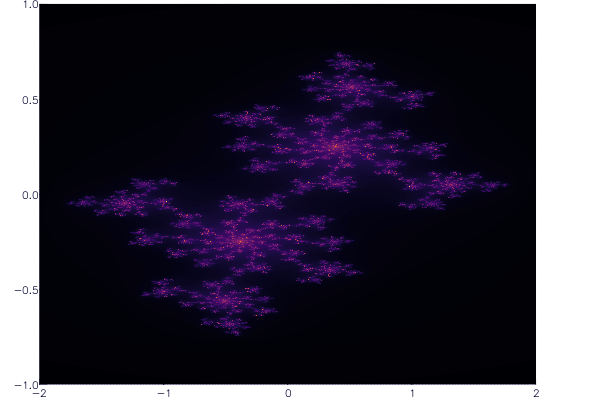

In [14]:
using Images
using FileIO
img = load("julia.png")